<a href="https://colab.research.google.com/github/FilippoAiraldi/RL-demos/blob/main/racetrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Racetrack

Exercise 5.21 from "Reinforcement Learning: an introduction" by Sutton & Barto. \\
Inspired by: https://github.com/laxatives/rl/blob/master/racetrack_monte_carlo.ipynb

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding

import numpy as np
import itertools

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from typing import Tuple, List, Callable, Dict, Union, Iterable

## Definitions

### Utils

#### Constants and helper funcs

In [ ]:
MAX_VELOCITY = 5
TILE_OUTSIDE = 0
TILE_TRACK = 1
TILE_START = 2
TILE_FINISH = 3
REWARD_FINISH = 0
REWARD_STEP = -1
REWARD_CRASH = -10
TRACKS = []
TRACKS.append(np.array([
    [0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,3],
    [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3],
    [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3],
    [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,0,2,2,2,2,2,2,0,0,0,0,0,0,0,0]]))
TRACKS.append(np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3],     
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3], 
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0]]))
TRACKS.append(np.array([
    [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
    [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
    [0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
    [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
    [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
    [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1],     
    [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1], 
    [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1], 
    [1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2], 
    [1,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
    [1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],     
    [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],    
    [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],    
    [0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],    
    [0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],    
    [0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,3,0,0,0,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,0,0,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,0,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,0,0,0,0,0,0,0,0]]))
for t in TRACKS: t.flags.writeable = False

add_2d = lambda a, b: (a[0] + b[0], a[1] + b[1]) if isinstance(b, tuple) else (a[0] + b, a[1] + b)

State = Tuple[int, int, int, int]
get_vel = lambda state: state[2:]
get_pos_vel = lambda state: (state[:2], state[2:])
state2idx = lambda state: (*state[:2], *add_2d(state[2:], MAX_VELOCITY - 1)) # vel from (-4,4) to (0,8) 
idx2state = lambda obs: (*obs[:2], *add_2d(state[2:], 1 - MAX_VELOCITY))     # vel from (0,8) to (-4,4) 

Action = Tuple[int, int]
ACTIONS = list(itertools.product((-1, 0, 1), (-1, 0, 1)))
ACTIONS_IDX = { a: i for i, a in enumerate(ACTIONS) }
idx2act = lambda i: ACTIONS[i]
act2idx = lambda act: ACTIONS_IDX[act]

def get_actions(state: State, as_idx: bool = False) -> List[Action]:
    """Returns a list of available actions in the given state."""
    v = get_vel(state)
    vx, vy = v
    dx = (-1, 0) if vx == MAX_VELOCITY - 1 else (0, 1) if vx == 1 - MAX_VELOCITY else (-1, 0, 1)
    dy = (-1, 0) if vy == MAX_VELOCITY - 1 else (0, 1) if vy == 1 - MAX_VELOCITY else (-1, 0, 1)
    acts = [a for a in itertools.product(dx, dy) if add_2d(v, a) != (0, 0)]
    if as_idx: acts = list(map(act2idx, acts))
    return acts

state_action_shape = lambda env: (*env.observation_space.nvec, env.action_space.nvec.prod())

#### Digital Differential Analysis for ray casting

In [ ]:
def dda(p: Tuple[float, float], v: Tuple[float, float], 
        collision_check: Callable[[int, int], bool], max_iters: int = 100) -> List[Tuple[int, int]]:
    """
    Casts a ray from the  position p along the vector v till a collision is detected.
    Inspired by: https://lodev.org/cgtutor/raycasting.html
    """ 
   
    if v == (0, 0): return []
    posX, posY = p[0], p[1]
    mapX, mapY = int(posX), int(posY)
    end = add_2d(p, v)
    n = np.sqrt(v[0] * v[0] + v[1] * v[1])
    rayDirX, rayDirY = v[0] / n, v[1] / n
    deltaDistX = 0 if rayDirY == 0 else 1 if rayDirX == 0 else abs(1 / rayDirX) 
    deltaDistY = 0 if rayDirX == 0 else 1 if rayDirY == 0 else abs(1 / rayDirY)    
    
    stepX, sideDistX = (-1, (posX - mapX) * deltaDistX) if rayDirX < 0 else (1, (mapX + 1 - posX) * deltaDistX)
    stepY, sideDistY = (-1, (posY - mapY) * deltaDistY) if rayDirY < 0 else (1, (mapY + 1 - posY) * deltaDistY)

    for _ in range(max_iters):
        if sideDistX < sideDistY:
            sideDistX += deltaDistX
            mapX += stepX
        elif sideDistX > sideDistY:
            sideDistY += deltaDistY
            mapY += stepY
        else:
            sideDistX += deltaDistX
            mapX += stepX
            sideDistY += deltaDistY
            mapY += stepY
        yield mapX, mapY
        if collision_check(mapX, mapY): break

### Environment

In [ ]:
class BoxedMultiDiscrete(spaces.MultiDiscrete):
    """
    Adds a low and high parameter to the multidiscrete space to 
    specify the range of each dimension.
    """
    # def __init__(self, nvec, low):
    def __init__(self, low, high = None, nvec = None):
        assert high or nvec, 'either high or nvec must be specified'    
        if high and not nvec:   nvec = np.asarray(high) - np.asarray(low) + 1
        elif nvec and not high: high = np.asarray(nvec) + np.asarray(low) - 1
        super(BoxedMultiDiscrete, self).__init__(nvec)
        self.high = np.asarray(high, dtype = np.int64)
        self.low = np.asarray(low, dtype = np.int64)
        assert self.nvec.shape == self.low.shape == self.high.shape, 'nvec, low and high must have the same number of elements'
        assert (self.high - self.low + 1 - self.nvec == 0).all(), 'ranges are incompatible'

    def sample(self):
        return (self.np_random.random_sample(self.nvec.shape) * self.nvec).astype(self.dtype) + self.low

    def contains(self, x):
        if isinstance(x, (list, tuple)): x = np.array(x) 
        x -= self.low
        return x.shape == self.shape and (0 <= x).all() and (x < self.nvec).all()

    def unbias(self, value):
        return np.asarray(value) - self.low

    def __repr__(self):
        return f'BoxedMultiDiscrete(nvec = {self.nvec}, low = {self.low}, high = {self.high})'

In [ ]:
def run_dda(pos, vel, collision_check):
    """Interface method for calling DDA in the right way from the env."""
    pos = add_2d(pos, 0.5)  # move to middle of tile
    *_, new_pos = dda(pos, vel, collision_check) # take only last iterable
    return new_pos

class Racetrack(gym.Env):
    """
    Discrete racetrack. A car tries to reach the finish line from a 
    starting line, ending the episode. Crashing onto boundaries resets
    the car to a random starting line tile. Velocity can in/decremented,
    or left unchanged, and it is limited to a maximum and cannot be zero
    in magnitude.
    Noise can sometimes happen, setting both velocity (x- and y-) to zero.

    Available actions are:
        Increment, decrement or leave velocity unchanged. Since the velocity 
        is a 2D vector, there are 9 total actions. The order is given by:
        `actions = list(itertools.product([-1, 0, 1], [-1, 0, 1]))`
    
    Rewards are:
        -1 for each step until the car crosses the finish line.

    Observations are:
        a 2D tuple corresponding to the current car tile.
    """

    metadata = { 'render.modes': ['rgb_array'] }

    def __init__(self, ver: int = 1, init_start: Tuple[int, int] = None,
                 slippage_prob: float = 0.1, done_on_collision: bool = False) -> None:
        super(Racetrack, self).__init__()
        assert 0 < ver <= len(TRACKS), f'avaible versions are from 1 to {len(TRACKS)}.'
        self.done_on_collision = done_on_collision
        self.slippage = slippage_prob
        self.coords = TRACKS[ver - 1]
        self.coords = np.pad(self.coords, 1, 'constant', constant_values = TILE_OUTSIDE)
        self.action_space = BoxedMultiDiscrete(low = (-1, -1), high = (1, 1))
        self.observation_space = BoxedMultiDiscrete(low = (0, 0, 1 - MAX_VELOCITY, 1 - MAX_VELOCITY), 
                                                    high = (*add_2d(self.coords.shape, -1), MAX_VELOCITY - 1, MAX_VELOCITY - 1))
        self._start_pos = list(map(tuple, np.argwhere(self.coords == TILE_START)))        
        self.seed()
        self.reset()

    def seed(self, seed: int = None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def unbias_state(self, state: State) -> State:
        return tuple(self.observation_space.unbias(state))

    def step(self, a: int) -> Tuple[State, int, bool, Dict]:
        assert self.action_space.contains(a), f'invalid action {a}'
        self.last_action = a

        pos, vel = get_pos_vel(self._state)
        new_vel = add_2d(vel, a) if self.np_random.random() > self.slippage or vel == (0, 0) else vel # don't slip at start
        target_pos = add_2d(pos, new_vel)

        assert new_vel != (0, 0), f'invalid null velocity (state: {self._state}, action: {a})'
        collision = lambda x, y: (x, y) == target_pos or self.coords[x, y] in [TILE_OUTSIDE, TILE_FINISH]
        new_pos = run_dda(pos, new_vel, collision)

        self.state = (*new_pos, *new_vel)    
        tile = self.coords[new_pos]
        if tile == TILE_FINISH:
            return self.state, REWARD_FINISH, True, { 'collision_tile': TILE_FINISH }
        if tile == TILE_OUTSIDE: 
            s = self.reset()
            return s, REWARD_CRASH, self.done_on_collision, { 'collision_tile': TILE_OUTSIDE }
        return self.state, REWARD_STEP, False, {}

    def random_action(self, state: State = None) -> Action:
        acts = get_actions(state if state else self.state, as_idx = True)
        return idx2act(self.np_random.choice(acts))

    def reset(self, init_start: Tuple[int, int] = None) -> State:
        if init_start is None: 
            init_start = self._start_pos[self.np_random.choice(len(self._start_pos))]
        assert self.coords[init_start] == TILE_START, 'point not on start line'
        self._state = (*init_start, 0, 0) # directly set _state to avoid check on null vel
        self.last_action = (0, 0)
        return self.state

    @property
    def state(self) -> State: return self._state

    @state.setter
    def state(self, value: State) -> None:
        vel = get_vel(value)
        assert self.observation_space.contains(value) and vel != (0, 0), f'invalid state {value}'
        self._state = value

    def render(self, mode: str = 'rgb_array', draw_vel: bool = True, draw_action: bool = True, scale: float = 1) -> np.ndarray: 
        assert mode == 'rgb_array', 'unsupported render mode'
        canvas = np.zeros((*self.coords.shape, 3), dtype = np.uint8)
        grass = np.array((94, 209, 109))
        track = np.array((135, 125, 127))
        start = np.array((232, 71, 101))
        finish = start
        car = np.array((71, 138, 232))
        traj = np.array((139, 173, 221))

        palette = [(grass, TILE_OUTSIDE), (track, TILE_TRACK), (start, TILE_START), (finish, TILE_FINISH)]
        for color, tile in palette:
            canvas[self.coords == tile, :] = color

        pos, vel = get_pos_vel(self._state)
        new_pos = (pos[0] + vel[0], pos[1] + vel[1])
        canvas[pos] = car
        if draw_vel and vel != (0, 0):
            for p in dda(add_2d(pos, 0.5), vel, lambda x, y: (x, y) == new_pos or self.coords[x, y] in [TILE_OUTSIDE, TILE_FINISH]):
                canvas[p] = traj
        if scale != 1:
            sz = (int(canvas.shape[1] * scale), int(canvas.shape[0] * scale))
            canvas = cv2.resize(canvas, dsize = sz, interpolation = cv2.INTER_NEAREST)

        if draw_action:
            w = canvas.shape[1]
            pedal = np.full((w // 2, w, 3), 200, dtype = np.uint8)
            acc = sum(a * v for a, v in zip(self.last_action, get_vel(self.state)))
            if acc == 2:    color = np.array((60, 240, 60))
            elif acc == 1:  color = np.array((60, 180, 60))
            elif acc == 0:  color = 100
            elif acc == -1: color = np.array((180, 60, 60))
            elif acc == -2: color = np.array((240, 60, 60))
            m = 20
            pedal[m:-m, m:-m] = color
            canvas = np.concatenate((canvas, pedal), axis = 0)
        return canvas

## Visualization

In [ ]:
def show_render(canvas: np.ndarray, use_cv2: bool = True) -> None:
    """Shows the render of the environment."""
    if use_cv2:
        cv2_imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    else:
        im = plt.matshow(canvas)
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)

def plot_action_values(Q: np.ndarray, env: Racetrack, state: State = None, reduction = lambda q: q.mean((2, 3)), 
                       title: str = 'Action values', figsize: Tuple[int, int] = (13, 6)) -> None:
    """
    Plots action values for the track. Values are plotted for the given velocity (in the state) if provided;
    otherwise, a reduction method over the all velocities is used.
    """
    
    if state:
        state = env.unbias_state(state)
        data = Q[:, :, state[2], state[3]]
    else:
        data = reduction(Q)
        assert data.shape == (*Q.shape[:2], Q.shape[-1]), 'invalid reduction'
    fig, ax = plt.subplots(figsize = figsize) 
    cmap = plt.get_cmap('hot')
    cmap.set_bad(color = [0.9] * 3)
    im = ax.matshow(data.max(2), cmap = cmap)    
    fig.colorbar(im, ax = ax)
    if title: ax.set_title(title)

## Solvers

### Utils

In [ ]:
def get_initial_action_values(env, val = None, rand = False, nan_outside = True):
    if rand: 
        Q = env.np_random.rand(*state_action_shape(env))
    else: 
        if val is None: val = 0
        Q = np.full(state_action_shape(env), val)
        Q = np.zeros(state_action_shape(env))
    if nan_outside: Q[env.coords == TILE_OUTSIDE] = np.nan 
    return Q

def update_returns(returns, key, x):
    avg, N = returns[key] if key in returns else (0.0, 0)
    returns[key] = (avg + (x - avg) / (N + 1), N + 1)
    return returns

to_unbias_pair = lambda env, state, action: (*env.unbias_state(state), act2idx(action))

def generate_episode(env, policy, a0_random = False):
    st = env.reset()
    at = env.random_action(st) if a0_random else policy(st)
    S, A, R = [], [], []
    while True:
        st_1, rt_1, done, _ = env.step(at)
        S.append(st)
        A.append(at)
        R.append(rt_1)
        if done: break
        st = st_1
        at = policy(st)
    return S, A, R 

def argmax_on_valid_actions(env, Q, state):
    valid_acts = get_actions(state, as_idx = True)
    state = env.unbias_state(state)
    acts, q_max = [], -np.inf
    for i, q in enumerate(Q[state]):
        if i not in valid_acts: continue
        if q == q_max: acts.append(i)
        elif q > q_max: acts, q_max = [i], q
    return idx2act(acts[0] if len(acts) == 1 else env.np_random.choice(acts))

### On-policy Monte Carlo Control

In [60]:
def onpolicy_monte_carlo_control(env: Racetrack, init_Q: np.ndarray = None, gamma: float = 0.9, eps: float = 0.01,
                                 iters: int = 2000, first_visit: bool = False, log: int = None) -> np.ndarray:
    returns = {} # hosts mean return and occurences count for each state-pair
    Q = init_Q if init_Q is not None else get_initial_action_values(env)
    policy = lambda s: argmax_on_valid_actions(env, Q, s) if env.np_random.random() > eps else env.random_action(s)
    
    if first_visit:
        episode_returns = {} # host return for each state-pair per episode
        for i in tqdm(range(iters), total = iters):
            # simulate
            S, A, R = generate_episode(env, policy, a0_random = True)

            # replay backwards
            episode_returns.clear()
            G = 0
            for st, at, rt_1 in reversed(list(zip(S, A, R))):
                G = gamma * G + rt_1
                sa_pair = to_unbias_pair(env, st, at)
                episode_returns[sa_pair] = G

            # update returns estimates with only the first visits
            for sa_pair, G in episode_returns.items():
                returns = update_returns(returns, sa_pair, G)
                Q[sa_pair] = returns[sa_pair][0]
    
            # log if requested
            if log and (i + 1) % log == 0:
                plot_action_values(Q, env, title = f'Action values ({i + 1}/{iters})')
    else:
        for i in tqdm(range(iters), total = iters):
            # simulate
            S, A, R = generate_episode(env, policy, a0_random = True)
            
            # replay backwards
            G = 0
            for st, at, rt_1 in reversed(list(zip(S, A, R))):
                G = gamma * G + rt_1
                # update returns estimates for each visit
                sa_pair = to_unbias_pair(env, st, at)
                returns = update_returns(returns, sa_pair, G)
                Q[sa_pair] = returns[sa_pair][0]

            # log if requested
            if log and (i + 1) % log == 0:
                plot_action_values(Q, env, title = f'Action values ({i + 1}/{iters})')
    return Q

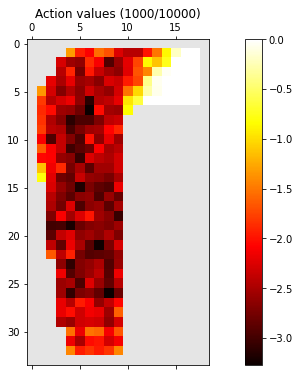

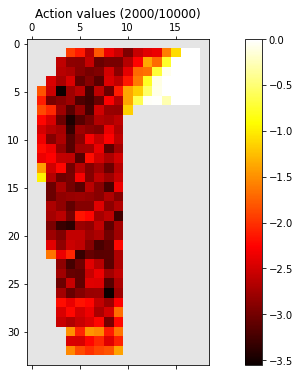

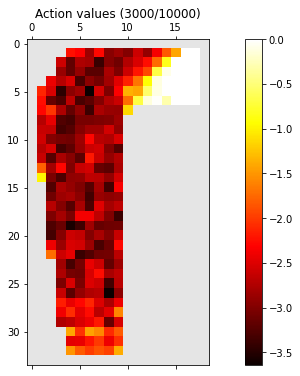

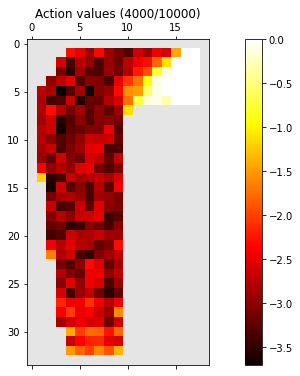

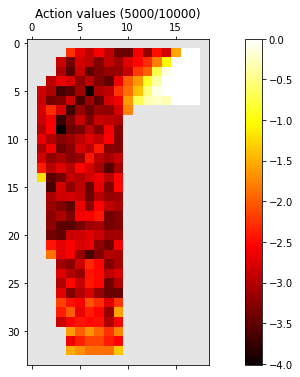

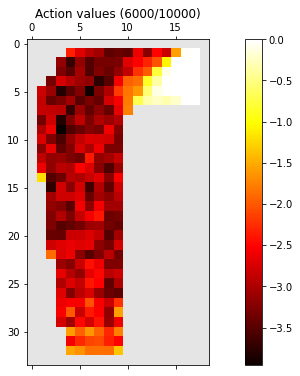

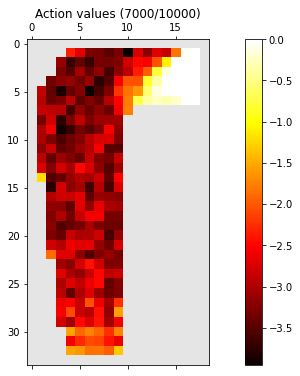

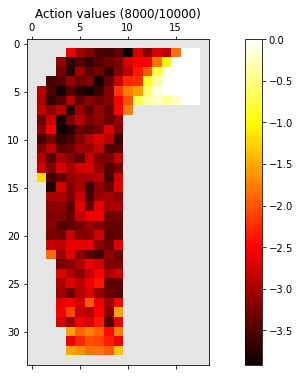

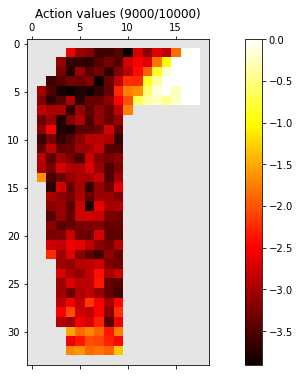

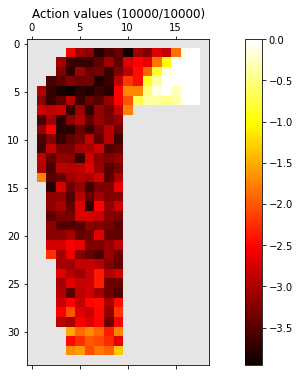

In [63]:
env = Racetrack(ver = 1, done_on_collision = False)
iters = int(1e4)
action_values = onpolicy_monte_carlo_control(env, iters = iters, 
                                             log = int(iters // 10), first_visit = False, eps = 0.33)

## Test

In [67]:
def test_policy(env: Racetrack, policy: Callable[[State], Action], T: int = None, animate: bool = True) -> None:
    if T is None: T = int(1e4)
    if animate:
        !apt -qq install xvfb
        !pip install -qq gym-notebook-wrapper
        import gnwrapper
        show = lambda e: e.render(scale = 10)
        env = gnwrapper.LoopAnimation(env) 
    else:
        show = lambda e: show_render(e.render(scale = 10))
    env.reset()
    show(env)
    for i in tqdm(range(T), total = T):
        a = policy(env.state)
        s, r, d, info = env.step(a) 
        show(env)
        if d: 
            if info['collision_tile'] == TILE_FINISH:
                print(f'Finished ({i}/{T})')
            break
    if animate: env.display(interval = 150)

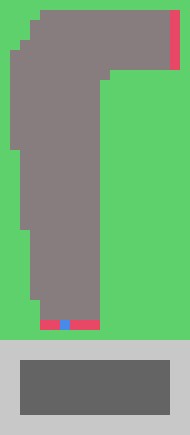

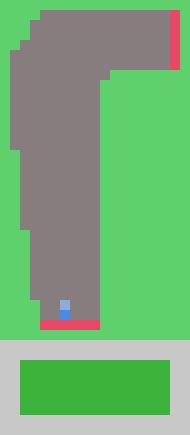

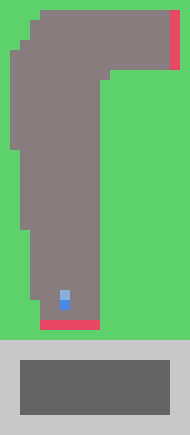

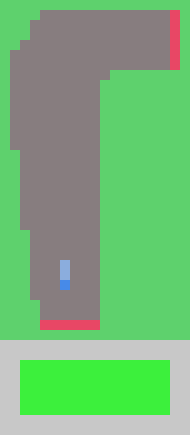

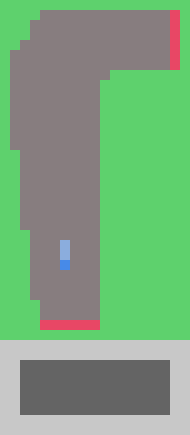

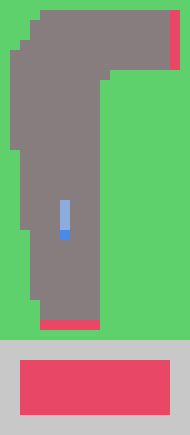

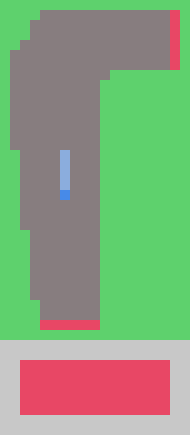

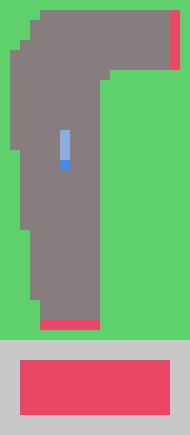

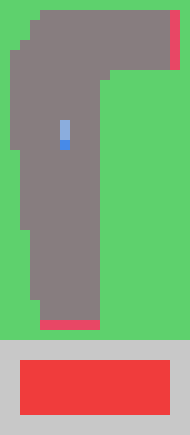

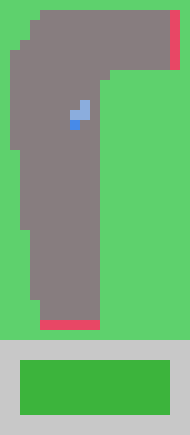

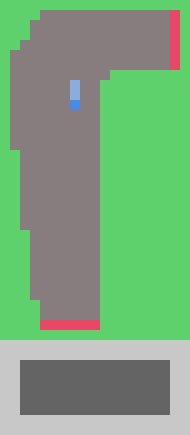

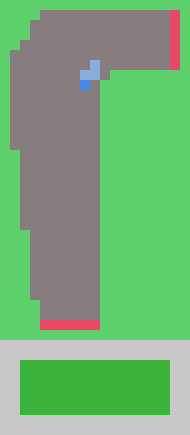

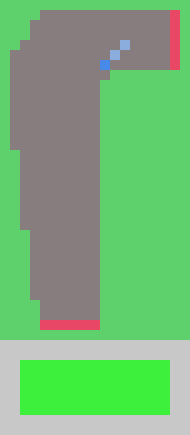

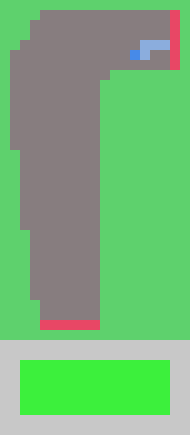

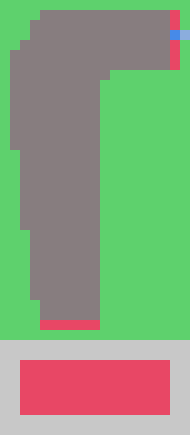

Finished (13/100)


In [69]:
env = Racetrack(ver = 1, slippage_prob = 0)
policy = lambda s: argmax_on_valid_actions(env, action_values, s)
# policy = lambda s: env.random_action(s)
test_policy(env, policy, T = int(1e2), animate = False)